In [246]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

### 1. Load data

In [247]:
df = pd.read_csv('Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


### 2. Exploration, Cleanning & preprocessing

In [248]:
df_explore = df.drop(['Id'], axis=1)
df_explore.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [249]:
df_explore.tail()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [250]:
df_explore.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [251]:
df_explore['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [252]:
# the dataset has got 150 samples and 5 columns (we removed the id's)
df_explore.shape

(150, 5)

In [253]:
# we check here if it has any null values and if yes then how many
df_explore.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

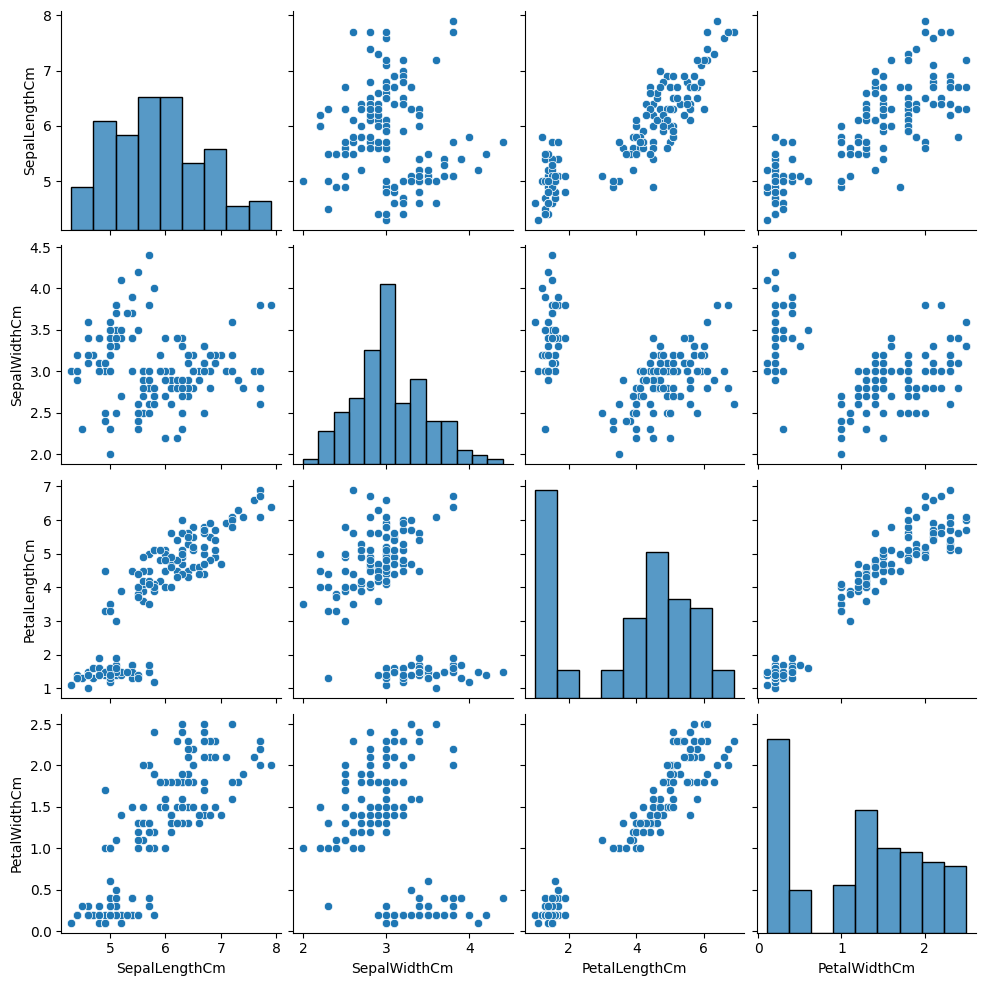

In [254]:
sns.pairplot(df_explore)

In [255]:
# Now we will change the class values with numbers to it's easy to predict
class_mapping = {'Iris-setosa':1, 'Iris-versicolor':2, 'Iris-virginica':3}
df_explore['Species'] = df['Species'].replace(class_mapping)

### 3. Load Data for Training

In [256]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = df_explore.iloc[:,:4] # selectign first 4 columns as X
labels = df_explore['Species']

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

X = data.values
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [257]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [258]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [259]:
X_train = X_train.to(torch.float32)
X_test = X_test.to(torch.float32)
y_train = y_train.to(torch.int64)
y_test = y_test.to(torch.int64)

In [260]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([120, 4]),
 torch.Size([30, 4]),
 torch.Size([120]),
 torch.Size([30]))

### 4. Create a simple neural network

In [262]:
class NeuralNet(nn.Module):
  def __init__(self, input_size :int, hidden_units: int, num_classes:int):
    super().__init__()
    self.layer1 = nn.Linear(in_features = input_size, out_features = hidden_units)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(in_features = hidden_units, out_features=num_classes)
    # self.softmax = nn.Softmax(dim=1)


  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    return x

In [263]:
model = NeuralNet(input_size = 4, hidden_units =10, num_classes= 3 )
model

NeuralNet(
  (layer1): Linear(in_features=4, out_features=10, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=10, out_features=3, bias=True)
)

### 5. Gradient Descent

$ Batch Gradient Descent: $


$\theta_{j} := \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)}
\$

Stochastic Gradient Descent:

$\theta_{j} := \theta_{j} - \alpha (h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)}\$


Here m is the batchsize, $h_{\theta}$ is function that we apply on data and we get the output $h_{\theta}(x^{(i)})$. $y^{(i)}$ is label. $i$  is the dimension of the variables. $\alpha$ is the learning rate and $m$ is the batch size. They are called hyeper paeamerers.

While the equations are update rules for the neural network's parameter. They will be updated at the end of each training epoch.

More Can be found here: https://en.wikipedia.org/wiki/Gradient_descent

### 6. Training

In [264]:
lr = 0.05

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [265]:
# let's code an acccuracy function to evaluate our model
def calculate_accuracy(y_pred, y_true):
  y_pred = y_pred.argmax(dim=1)
  correct = (y_pred == y_true).sum().item()
  return correct/len(y_pred)

In [270]:
# SInce we have setup up our optimizer and loss function we can start traning our network now

from tqdm.auto import tqdm

torch.manual_seed(42)
epochs = 20
train_loss = []
test_loss = []

train_acc = []
test_acc = []

for epoch in tqdm(range(epochs)):
  model.train()
  loss, acc = 0, 0
  y_pred = model(X_train)
  print("Y_PRED :::::::", y_pred.shape)
  loss += criterion(y_pred, y_train)


  acc += calculate_accuracy(y_pred, y_train)

  # we reseting / 0 ing our gradient parameters for every loop
  # otherwise it will keep adding oldergradients to model
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # update the parameter
  optimizer.step()

  train_loss.append(loss.detach().numpy())
  train_acc.append(acc)

  model.eval()
  # testing
  with torch.inference_mode():
    y_pred = model(X_test)
    loss = criterion(y_pred, y_test)
    acc = calculate_accuracy(y_pred, y_test)

    test_loss.append(loss.detach().numpy())
    test_acc.append(acc)

  print(f"Epoch{epoch} Train Loss: {train_loss[epoch]} , Train Acc: {train_acc[epoch]} | Test loss: {test_loss[epoch]}, Test acc: {test_acc[epoch]}")

  0%|          | 0/20 [00:00<?, ?it/s]

Y_PRED ::::::: torch.Size([120, 3])
Epoch0 Train Loss: 0.5758571028709412 , Train Acc: 0.8833333333333333 | Test loss: 0.5658045411109924, Test acc: 0.8333333333333334
Y_PRED ::::::: torch.Size([120, 3])
Epoch1 Train Loss: 0.5671691298484802 , Train Acc: 0.8833333333333333 | Test loss: 0.5577117204666138, Test acc: 0.8333333333333334
Y_PRED ::::::: torch.Size([120, 3])
Epoch2 Train Loss: 0.5588738322257996 , Train Acc: 0.8916666666666667 | Test loss: 0.5499950051307678, Test acc: 0.8333333333333334
Y_PRED ::::::: torch.Size([120, 3])
Epoch3 Train Loss: 0.5509468913078308 , Train Acc: 0.9 | Test loss: 0.5426197648048401, Test acc: 0.8333333333333334
Y_PRED ::::::: torch.Size([120, 3])
Epoch4 Train Loss: 0.5433655381202698 , Train Acc: 0.9 | Test loss: 0.5355695486068726, Test acc: 0.8666666666666667
Y_PRED ::::::: torch.Size([120, 3])
Epoch5 Train Loss: 0.5361077189445496 , Train Acc: 0.9 | Test loss: 0.5288211107254028, Test acc: 0.8666666666666667
Y_PRED ::::::: torch.Size([120, 3])
E

### 7. Plot Trainng and Testing Graphs

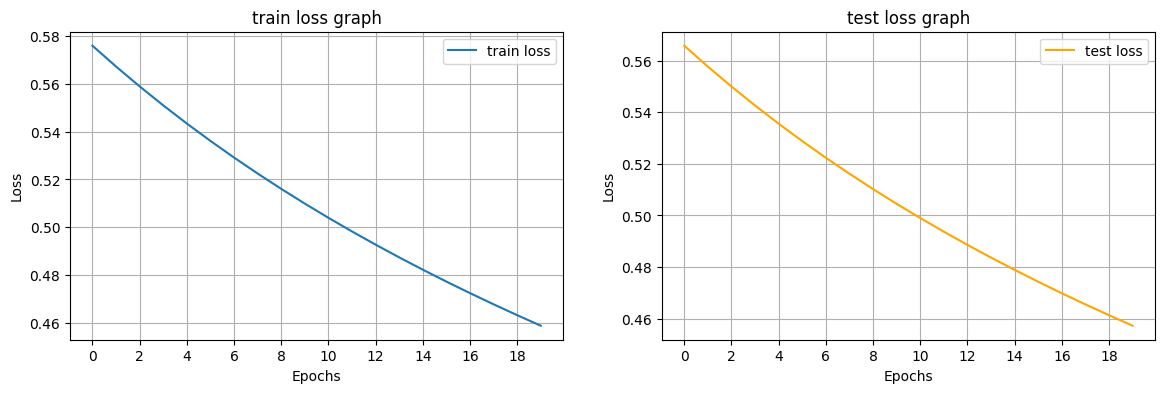

In [271]:
figure = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(train_loss)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(0,epochs, 2))
plt.legend(["train loss"])
plt.title("train loss graph")

plt.subplot(1,2,2)
plt.plot(test_loss, color='orange')
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(0,epochs, 2))
plt.legend(["test loss"])
plt.title("test loss graph")
plt.show()

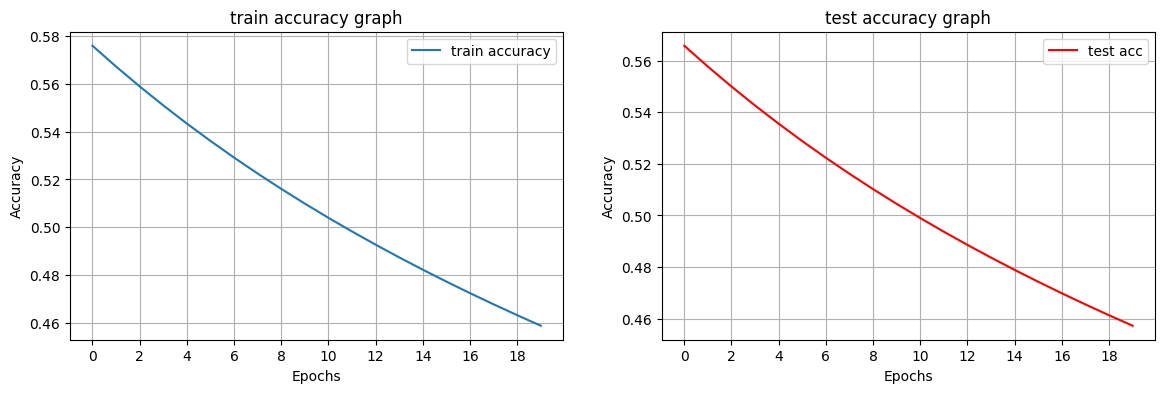

In [272]:
figure = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(train_loss)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(range(0,epochs, 2))
plt.legend(["train accuracy"])
plt.title("train accuracy graph")

plt.subplot(1,2,2)
plt.plot(test_loss, color='red')
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(range(0,epochs, 2))
plt.legend(["test acc"])
plt.title("test accuracy graph")
plt.show()

### 8. Make a confusion matrix

<Axes: >

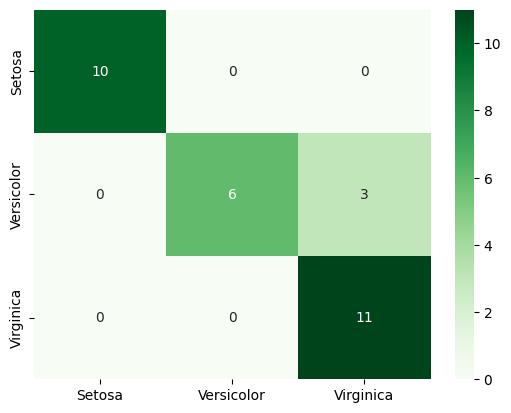

In [280]:
from sklearn.metrics import confusion_matrix

model.eval()
with torch.no_grad():
  y_pred = model(X_test)
  out_accuracy = calculate_accuracy(y_pred, y_test)
  y_pred = y_pred.argmax(dim=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=["Setosa", "Versicolor", "Virginica"], yticklabels=["Setosa", "Versicolor", "Virginica"], cmap="Greens")

In [281]:
y_test, y_pred

(tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 0, 0]),
 tensor([2, 0, 2, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 0, 0]))

In [278]:
print(f"Our Accuracy is : ",out_accuracy)

Our Accuracy is :  0.9
